### **Load the dataset to dataframe**

In [63]:
%cd packetbaseml

c:\Users\bkosinski\Desktop\STUDIA\INZ\modules\ML-API\packetbaseml


In [64]:
from src.data.dataset import Dataset

nb15_v2: Dataset = Dataset(
    "./data/NB15v2/interim/NF-UNSW-NB15-v2.csv"
)

In [40]:
len(nb15_v2.data.columns)

45

### **Dataset analysis**

In [3]:
nb15_v2.data.groupby(["Attack", "Label"])["Attack",].count()

,,Attack
Attack,Label,
Analysis,1,2299
Backdoor,1,2169
Benign,0,2295222
DoS,1,5794
Exploits,1,31551
Fuzzers,1,22310
Generic,1,16560
Reconnaissance,1,12779
Shellcode,1,1427


In [4]:
print(f"Columns: {', '.join(nb15_v2.data.columns.tolist())}")

Columns: IPV4_SRC_ADDR, L4_SRC_PORT, IPV4_DST_ADDR, L4_DST_PORT, PROTOCOL, L7_PROTO, IN_BYTES, IN_PKTS, OUT_BYTES, OUT_PKTS, TCP_FLAGS, CLIENT_TCP_FLAGS, SERVER_TCP_FLAGS, FLOW_DURATION_MILLISECONDS, DURATION_IN, DURATION_OUT, MIN_TTL, MAX_TTL, LONGEST_FLOW_PKT, SHORTEST_FLOW_PKT, MIN_IP_PKT_LEN, MAX_IP_PKT_LEN, SRC_TO_DST_SECOND_BYTES, DST_TO_SRC_SECOND_BYTES, RETRANSMITTED_IN_BYTES, RETRANSMITTED_IN_PKTS, RETRANSMITTED_OUT_BYTES, RETRANSMITTED_OUT_PKTS, SRC_TO_DST_AVG_THROUGHPUT, DST_TO_SRC_AVG_THROUGHPUT, NUM_PKTS_UP_TO_128_BYTES, NUM_PKTS_128_TO_256_BYTES, NUM_PKTS_256_TO_512_BYTES, NUM_PKTS_512_TO_1024_BYTES, NUM_PKTS_1024_TO_1514_BYTES, TCP_WIN_MAX_IN, TCP_WIN_MAX_OUT, ICMP_TYPE, ICMP_IPV4_TYPE, DNS_QUERY_ID, DNS_QUERY_TYPE, DNS_TTL_ANSWER, FTP_COMMAND_RET_CODE, Label, Attack


### **Fixing dataset**

In [65]:
columns_to_drop = ["IPV4_SRC_ADDR", "L4_SRC_PORT", "IPV4_DST_ADDR", "L4_DST_PORT"]

nb15_v2.drop_columns(columns_to_drop)

In [66]:
nb15_v2.reduce_benign_class()

In [67]:
from src.data.labels import nb15v2_labels

nb15_v2.map_labels_to_idx(nb15v2_labels, 'Attack')

In [8]:
nb15_v2.data.groupby(["Attack", "Label"])["Attack",].count()

,,Attack
Attack,Label,
0,1,2299
1,1,2169
2,0,183618
3,1,5794
4,1,31551
5,1,22310
6,1,16560
7,1,12779
8,1,1427


In [68]:
corr = nb15_v2.data.corr()
corr["Label"].drop("Label").abs().max()

0.8509476764921544

In [69]:
corr["Label"].drop("Label").abs().median()

0.07878481490111201

In [60]:
corr["Label"].drop("Label").abs().mean()

0.1716686756211046

In [70]:
corr_threshold = 0.1

In [71]:
corr = nb15_v2.data.corr()
columns_to_drop = corr[
    (corr["Label"] >= -corr_threshold) & (corr["Label"] <= corr_threshold)
].index

# Print the columns to be dropped
print("Columns to be dropped due to low correlation with 'Label':")
print(columns_to_drop)

Columns to be dropped due to low correlation with 'Label':
Index(['L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'ICMP_TYPE', 'ICMP_IPV4_TYPE',
       'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'DNS_TTL_ANSWER'],
      dtype='object')


In [72]:
nb15_v2.drop_columns(columns_to_drop)

In [73]:
nb15_v2.data.to_csv('./data/NB15v2/interim/corr_data.csv')

In [74]:
len(nb15_v2.data.columns)

18

#### **Attributes' Heatmap**

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

label_corr = corr[["Label"]].drop(["Label"], axis=0)

num_attributes = label_corr.shape[0]
attributes_per_subplot = num_attributes // 4


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 20))

cmap = "rocket_r"


for i in range(4):
    start_idx = i * attributes_per_subplot
    end_idx = (i + 1) * attributes_per_subplot
    subset = label_corr[start_idx:end_idx]

    sns.heatmap(
        subset,
        cmap=cmap,
        annot=False,  
        vmax=1,
        center=0,
        square=True,  
        linewidths=0.2,
        cbar_kws={"shrink": 0.5},
        ax=axes[i],  
    )
    axes[i].set_title("Korelacja między Label a pozostałymi atrybutami")
    axes[i].set_xlabel("Label")
    axes[i].set_ylabel("Atrybuty")
    axes[i].tick_params(axis="y", labelsize=8)  

plt.tight_layout()

plt.savefig(f"./img/heatmaps/nb15_v2_heatmap_label_atrybuty_multicol.png")
plt.clf()

<Figure size 1200x2000 with 0 Axes>

In [ ]:
corr["Label"].drop("Label").abs().max()

### **Confusion matrix**

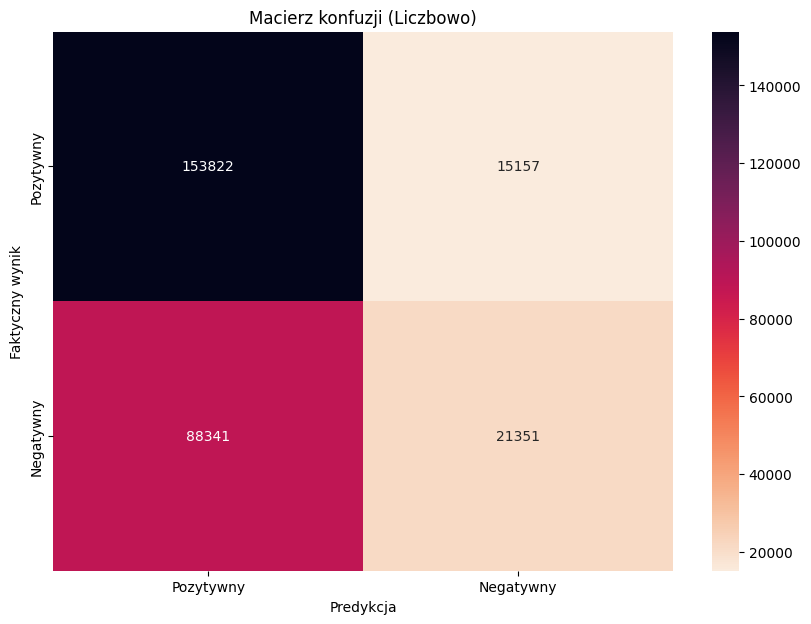

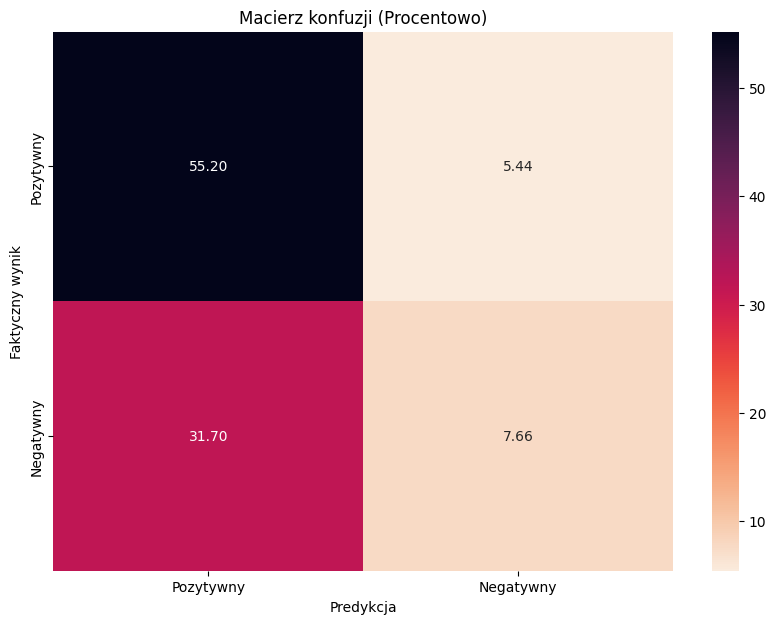

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_confusion_matrix(values, percentage=False):
    PP, FP, FN, TN = values["PP"], values["FP"], values["FN"], values["TN"]
    total = PP + FP + FN + TN

    matrix = np.array([[PP, FP], [FN, TN]])
    fmt = ".0f"

    if percentage:
        matrix = matrix / total * 100
        fmt = ".2f"

    labels = ["Pozytywny", "Negatywny"]

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        matrix,
        annot=True,
        fmt=fmt,
        cmap="rocket_r",
        xticklabels=labels,
        yticklabels=labels,
    )

    plt.title("Macierz konfuzji" + (" (Procentowo)" if percentage else " (Liczbowo)"))

    plt.show()


values = {"PP": 153822, "FP": 15157, "FN": 88341, "TN": 21351}

plot_confusion_matrix(values, percentage=False)
plot_confusion_matrix(values, percentage=True)